___
## Ciência dos Dados - PROJETO 3 - INSPER

___
#### Victor Arruda Niubó

#### Giovanni Pertence Cardoso dos Santos

#### Gustavo Schlieper Tessitore

#### Leonardo Cesari Costa
___

# Previsão da quantidade de views

___

## 1. INTRODUÇÃO

O objetivo do projeto é estimar a quantidade de visualizações que um vídeo terá com base no título, horário de publicação e as tags atribuidas aos vídeos.

___
## 2. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import itertools
import math
import json
import os
from scipy import stats
from scipy.stats import norm

In [ ]:
#remove mesagens de aviso do Pandas
pd.options.mode.chained_assignment = None
print('Esperamos trabalhar no diretório')
print(os.getcwd())

### BASE DE DADOS

In [ ]:
# Base de dados dos videos em destaque do youtube US
you_data = pd.read_csv("USvideos.csv")

you_data.drop_duplicates(subset = 'video_id', keep = 'last', inplace = True)

# jason que contém a relação id - categoria
ids = json.loads(open('US_category_id.json').read())


# filtro das variáveis de interesse
you_analysis = you_data.loc[you_data.views|you_data.title|you_data.tags|you_data.category_id,\
                           ['views', 'title', 'tags', 'category_id']]


In [ ]:
# separação da string das tags em uma lista de strings
tags_split = you_analysis.tags.str.split(pat = '|')
you_analysis['tags_split'] = tags_split
you_analysis.head()
you_ifn = you_analysis.copy()

In [ ]:
# Junta todas as strings em uma lista só para pder fazer um value_counts() e criar um
# dataframe com as tags e as frquencias de cada uma
merged = list(itertools.chain(*you_analysis.tags_split))
contador = pd.DataFrame({'col':merged})
limpino = contador[contador.col != '[none]']
dfl = limpino.col.value_counts().rename_axis('tags').reset_index(name='counts')
dfl = dfl[(dfl['counts'])> 10]

In [ ]:
%store dfl
%store you_data

In [32]:
dfl.head()

,tags,counts
0,funny,631
1,comedy,515
2,humor,277
3,comedian,227
4,music,213


In [ ]:
# Separa as linhas que contém certa tag
for ind,data in dfl.iterrows():
    var_df = you_analysis[you_analysis['tags'].str.contains(data['tags'])]
    x = list(var_df.index)
    you_analysis[data['tags']+'_freq'] = 0
    you_analysis.loc[x,[data['tags']+'_freq']] = data['counts']
    
# var_df = you_analysis['tags'].str.contains(dfl.tags[0])
# list(var_df)

In [ ]:
# Cria dataframe das views e frequência máxima
banana = pd.DataFrame()
banana['views'] = you_analysis['views']
banana['max_freq'] = you_analysis.iloc[:,5:].max(axis=1)

# Plota scatter 
ax = plt.gca()
ax.scatter(banana.max_freq, banana.views)
ax.set_yscale('log')

In [ ]:
# Transpose no dataframe para poder usar .nlargest()
you_freqs = you_analysis.iloc[:,5:]
trans = you_freqs.T

In [ ]:
#trans.rename(index=str, columns={e: "vid_{0}".format(e)})
%store trans
%store you_analysis
%store banana

In [ ]:
top3_sum = []
toto_sum = []
for ind, data in you_freqs.iterrows():
    top3_sum.append(data.nlargest(3).sum())
    toto_sum.append(data.sum())

In [ ]:
you_ifn['top3_freq']=top3_sum
%store you_ifn

In [ ]:
ax.scatter(you_ifn.top3_freq, you_ifn.views)
ax.set_yscale('log')

In [ ]:
#LEMBRANDO
x = you_ifn.top3_freq
y = you_ifn.views

#beta^0 e beta^1
yb = y.mean()
xb = x.mean()

Sxy = ((x -xb)*(y -yb)).sum()
Sxx = ((x -xb)**2).sum()

b1 = Sxy/Sxx
b0 = yb - b1*xb

x_v = np.linspace(x.min(), x.max(), 500)
y_v = b0 + b1*x_v

plt.plot(x_v,y_v, color="r") # resultados da regressão
plt.scatter(x, y); # dados
plt.gca().set_yscale('log')

In [ ]:
e = y - (b0 + b1*x) # Escreva sua fórmula dos resíduos aqui

stats.probplot(e, dist='norm', plot=plt);

In [ ]:
a = trans.copy().T.astype(str)
for i in a.columns:
    a[i] = a[i].str.replace('[1-9][0-9]*','1')

In [ ]:
a = a.astype(int)
n_tags = []
for ind,data in a.iterrows():
    n_tags.append(data.sum())

In [ ]:
mean_freqs = []
for e in range(len(n_tags)):
    mean_freqs.append(toto_sum[e]/n_tags[e])

### ANÁLISE DESCRITIVA

___
## C. MODELOS DE PREDIÇÃO

In [36]:
new_data = pd.DataFrame()
new_data['views'] = you_analysis['views']
new_data['top3_freq'] = top3_sum
new_data['n_tags'] = n_tags
new_data['mean_freqs'] = mean_freqs
new_data['funny'] = a['funny_freq']
new_data['comedy'] = a['comedy_freq']
new_data['humor'] = a['humor_freq']
new_data['music'] = a['music_freq']
new_data.head(17)


,views,top3_freq,n_tags,mean_freqs,funny,comedy,humor,music
10,81377,409,45,46.533333,0,0,0,0
36,288922,435,34,39.970588,0,0,0,0
41,34785,309,9,48.000000,0,0,0,0
55,1496225,347,22,36.090909,0,0,0,0
76,237307,69,5,19.200000,0,0,0,0
78,1497519,1135,41,109.341463,1,0,1,0
102,225286,1423,35,97.800000,1,1,1,0
104,5476737,375,29,30.931034,0,0,0,0
106,304926,339,17,55.294118,0,0,0,0
117,1017803,308,9,48.777778,0,0,0,0


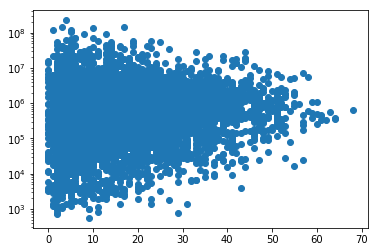

In [30]:
plt.gca().scatter(new_data.n_tags,new_data.views)
plt.gca().set_yscale('log')

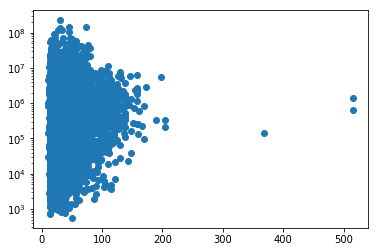

In [31]:
plt.gca().scatter(new_data.mean_freqs,new_data.views)
plt.gca().set_yscale('log')

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS